# VampNet Basics
This notebook walks you through the basics of generating music audio with a pre-trained VampNet. You will learn how to install VampNet, tokenize audio, mask it, prompt VampNet with masked audio, and get the output.


For more info on the tech behind VampNet see our publication:

[H. Flores, P. P. Seetharaman, R. Kumar, and B. Pardo, “VampNet: Music Generation via Masked Acoustic Token Modeling,” International Society of the Society of Music Information Retrieval (ISMIR), 2023.](https://interactiveaudiolab.github.io/assets/papers/ismir2023-flores-seetharaman-pardo.pdf)


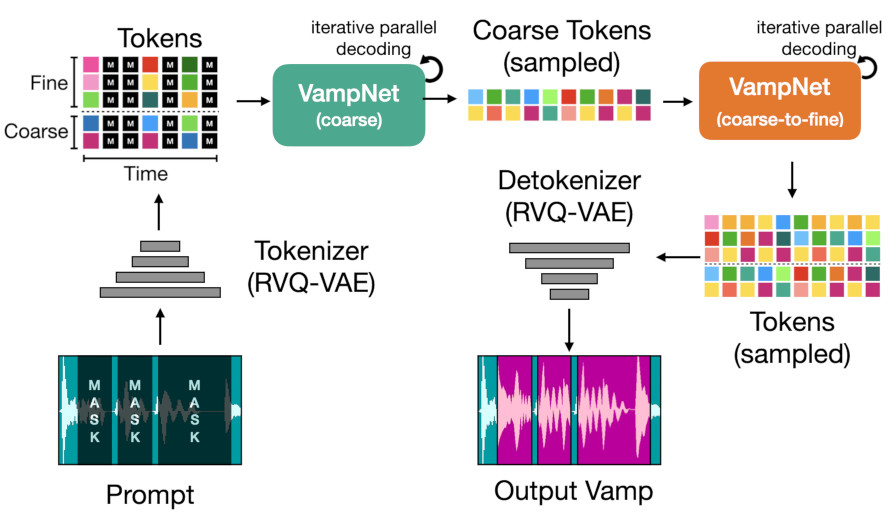



## Installing VampNet

To get VampNet, you'll need to clone the repository. Here's how.**bold text**

In [3]:
# The following magic command suppresses output to the notebook so you don't have to see all the installs.
%%capture

# Clone vampnet code to a local directory.
!git clone --recursive https://github.com/hugofloresgarcia/vampnet.git

# Make the code available to use by pip installing it.
import os
os.chdir("./vampnet")
!pip install  .

UsageError: Line magic function `%%capture` not found.


## Setting up VampNet

Import the needed code.

In [ ]:
from pathlib import Path
import audiotools as at #a helpful library from Descript for dealing with wavefiles
import vampnet
import torch

Set up a VampNet model, and put it in an interface.

In [ ]:
# load the audio tokenizer. The tokenizer takes audio waveforms and turns them into
# a low bitrate stream of tokens that make it easier for a Transformer (like vampnet)
# to process
codec = vampnet.load_codec()

# load the default pretrained model
model = vampnet.load_model("hugggof/vampnet-models:vampnet-base-best")

# An Interface is how you interact with vampnet to control it. Let's put the codec and
# model into an interface
interface = vampnet.interface.Interface(codec, model)

# THis line moves our processing to the GPU, which is much faster than using the CPU.
# NOTE: In Google colab, go to the "Runtime/Change-runtime-type" menu item and pick
# something that is not "CPU". This notebook was tested on colab with "T4 GPU" selected.
interface = interface.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


loading model hugggof/vampnet-models:vampnet-base-best from the huggingface hub.


## Encoding and decoding audio

Use audiotools to load an example audio file and display it.



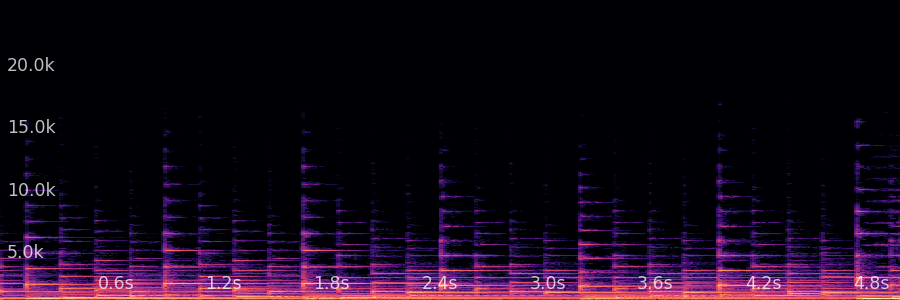
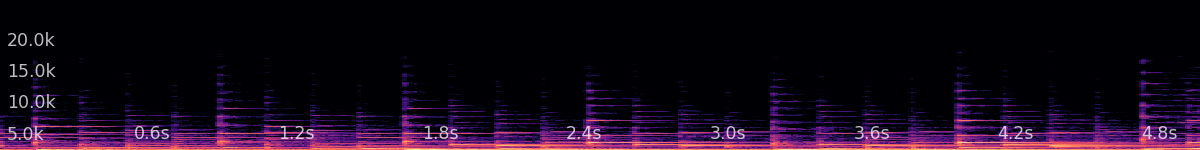

In [ ]:
signal = at.AudioSignal.excerpt(vampnet.ROOT / "assets" / "example_audio" / "fountain.mp3", duration=5.0)
signal.widget()

Encode the audio into acoustic tokens. This greatly compacts the audio so that
the Transformer inside VampNet can handle it quickly.  

TL;DR: Our encoder is based off the [Descript Audio Codec](https://arxiv.org/abs/2306.06546) tokenizer. It is a residual vector quantizer. This means that, for each time-step, it represents the audio as a multi-level encoding (nine levels, in our case), where the first level is a course estimate of the wave form and each succeeding level encodes the residual difference between the original waveform and the encoding created by the previous layers.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


the input signal has shape:  torch.Size([1, 2, 240000])  at sample-rate:  48000
the tokenized signal has shape:  torch.Size([1, 9, 430])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:797: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose1d(


the detokenized signal has shape:  torch.Size([1, 1, 220160])  at sample-rate:  44100
the resampled signal has shape:  torch.Size([1, 1, 239629])  at sample-rate:  48000



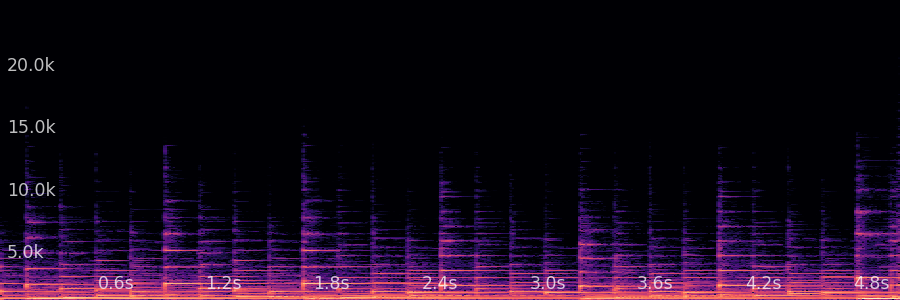
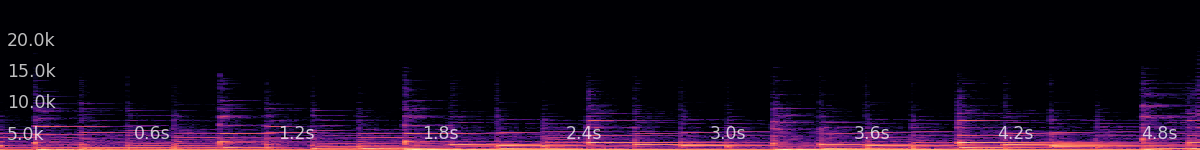

In [ ]:
# Get the tokens for the audio signal.
tokens = interface.encode(signal)

print('the input signal has shape: ', signal.shape, ' at sample-rate: ', signal.sample_rate)
print('the tokenized signal has shape: ', tokens.shape)

# Detokenizing the signal can be done easily, as follows.
signal_detokenized = interface.decode(tokens)
print('the detokenized signal has shape: ', signal_detokenized.shape, ' at sample-rate: ', signal_detokenized.sample_rate)

# Note that it decodes at a 44.1 kHz sample rate when detokenizing.
# Let's resample back up to 48 kHz
signal_detokenized = signal_detokenized.resample(48000)
print('the resampled signal has shape: ', signal_detokenized.shape, ' at sample-rate: ', signal_detokenized.sample_rate)

# let's look at the detokenized signal to compare it to the original
# NOTE: to view it, I have to put it back in the CPU from the GPU
signal_detokenized.cpu().widget()

# Applying a mask to the audio
VampNet is prompted (aka conditioned) by handing it tokenized audio where a portion of it has been masked out. It then fills in the blanks to be something that goes well with the un-masked audio.  Therefore, the key to using VampNet is doing good masking that prompts it to do just what you want. It is worth taking some time to understand how to mask.

 ### Making a prefix or suffix mask
 We can prompt our model with audio that we would like to make a continuation of by masking out the tokens at the end of the sequence. We can prompt our model to make a lead-in by masking out the initial portion of the token sequence.

In [ ]:
# Here is an example of how to mask the initial portion of the audio to prompt VampNet to make a lead-in

# build a prefix mask that will mask the first 10% of the tokens
n_tokens_to_mask = int(0.1 * tokens.shape[-1])
mask = vampnet.mask.inpaint(
    x=tokens, 
    n_prefix=n_tokens_to_mask, 
    n_suffix=0)

# Here is an example of how to mask out the final portion of the audio to prompt a continuation.
# build a suffix mask that will mask the last 20% of the tokens
n_tokens_to_mask = int(0.2 * tokens.shape[-1])
mask = vampnet.mask.inpaint(
    x=tokens, 
    n_prefix=0, 
    n_suffix=n_tokens_to_mask)

### Making an upper codebook (compression) mask
Upper codebook masks remove the fine-grained details of the audio signal by masking the `n`th codebook level an above for all timesteps, leaving only the lower tokens, and thus preserving the coarse structure like rhythm and sometimes pitch, but having to infer everything else. This can create interesting variations and shifts in timbre and texture of the generated audio. 

In [ ]:
### build a compression mask, masking from the 2nd codebook level above
mask = vampnet.mask.upper_codebook_mask(tokens, level=2)

### Making a periodic mask
When one vamps on a riff, the idea is to repeatedly play things like the original riff, but in variations.  One great way to get VampNet to do this is by making a periodic mask, where every ith timestep is masked out, prompting the network to make variations of the same pattern. Here's how.

From (hugo's) observations, a periodic prompt of 3 will often create a slight variation, 5 and 7 will create a bit more variation, and 13 and above will create a significant amount of variation. Feel free to experiment with other values, of course. 

In [ ]:
mask = vampnet.mask.periodic(
    z, 
    period=3 
)

### Composing masks
In a musicmaking scenario, you might want to combine these masks. For example, you might want to make a periodic mask that also has an upper codebook mask. This would prompt the network to make both rhythmic and timbral variations on a signal. 

You could compose these masks yourself by using logical operators like `vampnet.mask.mask_and(mask1, mask2)` or `vampnet.mask.mask_or(mask1, mask2)`, but the vampnet interface class also has a helper function, `build_mask` for combining the mask ops mentioned above. 

Here's an example of using build_mask:

In [ ]:
# build a mask for the tokens
mask = interface.build_mask(tokens,
    prefix_s=0.1, # prefix mask amount, in seconds.
    suffix_s=0.2, # suffix mask amount, in seconds.
    periodic_prompt=3,
    upper_codebook_mask=2,
)

## Generating output tokens with VampNet

Now that we have tokenized audio and a mask, we're ready to generate new audio.

VampNet is a language-model-style generative model that does parallel iterative decoding (see [our paper](https://interactiveaudiolab.github.io/assets/papers/ismir2023-flores-seetharaman-pardo.pdf) for more on this). 

At generation-time, the new audio tokens are sampled from a distribution. This means that you have choices to make about how, exactly, the sampling is done. 

This is controlled by the parameters passed to `vampnet.Interface.vamp()` and `vampnet.model.transformer.VampNet.generate()`. Here's what they do.

build_mask() parameters:
```py
    def build_mask(
        self,
        codec,
        mask_type: str = "prefix",
        mask_length: int = 100,
        upper_codebook_mask: bool = False,
        periodic_mask: int = 0,
    ):
        """
        Build a mask for generating a variation on an input sequence of tokens. 

        Args:
            codec: the codec to use for encoding // decoding tokens
            mask_type (str, optional): the type of mask to use. Defaults to "prefix".
            mask_length (int, optional): the length of the mask. Defaults to 100.
            upper_codebook_mask (bool, optional): whether to use an upper codebook mask. Defaults to False.
            periodic_mask (int, optional): the period of the mask. Defaults to 0.

        Returns:
            torch.Tensor: the mask
```


generate() parameters:
```py
    def generate(
        self,
        codec,
        start_tokens: Optional[torch.Tensor] = None,
        time_steps: int = 300,
        _sampling_steps: List[int] = [16, 4, 4, 2, 2, 2, 2, 1, 1],
        cross_x: Optional[torch.Tensor] = None,
        sampling_temperature: float = 1.0,
        mask: Optional[torch.Tensor] = None,
        mask_temperature: float = 10.5,
        typical_filtering=False,
        typical_mass=0.2,
        typical_min_tokens=1,
        top_p=None,
        seed: int = None, 
        sample_cutoff: float = 1.0,
        causal_weight: float = 0.0,
    ):
        """
        Generate a sequence of tokens from the model, 
        given a prompt and a mask. 

        Args:
            codec: the codec to use for encoding // decoding tokens
            start_tokens (Optional[torch.Tensor], optional): the starting tokens (aka prompt). 
            time_steps (int, optional): number of tokens to generate. only used if start_tokens is None. Defaults to 300.
            _sampling_steps (List[int], optional): number of sampling steps for each codebook level. Defaults to [16, 4, 4, 2, 2, 2, 2, 1, 1].
            cross_x (Optional[torch.Tensor], optional): DEPRECATED. cross attention tokens. Defaults to None.
            sampling_temperature (float, optional): sampling temperature. Defaults to 1.0.
            mask (Optional[torch.Tensor], optional): mask for the tokens. Defaults to None.
            mask_temperature (float, optional): temperature for mask sampling. note that this it NOT the same as sampling_temperature. You probably don't want to change this value, and instead change the sampling_temperature. . Defaults to 10.5. Refer to the vampnet paper for more information on this parameter: https://arxiv.org/abs/2307.04686
            typical_filtering (bool, optional): whether to use locally typical sampling (https://arxiv.org/abs/2202.00666). Defaults to False.
            typical_mass (float, optional): typical mass for typical filtering. Defaults to 0.2.
            typical_min_tokens (int, optional): minimum number of tokens for typical filtering. Defaults to 1.
            top_p ([type], optional): nucleus sampling: https://arxiv.org/abs/1904.09751. Defaults to None.
            seed (int, optional): random seed. Defaults to None.
            sample_cutoff (float, optional):  experimental feature. it's function is left as an exercise for the reader. use at your own risk. Defaults to 1.0. (off)
            causal_weight (float, optional):  experimental feature, from the bytedance stemgen paper: https://arxiv.org/abs/2312.08723. use at your own risk. Defaults to 0.0. (off)

        Returns:
            torch.Tensor: the generated tokens
```



vamp() parameters:
```py
    def vamp(self, 
        z: torch.Tensor, 
        mask: torch.Tensor, 
        return_mask:bool=False, 
        gen_fn: callable=None, 
        **kwargs
    ):
        """
        vamp on a sequence of codes z, given a mask. 

        Args:
            z (torch.Tensor): a sequence of codes. shape (batch_size, n_codebooks, seq_len)
            mask (torch.Tensor): a mask. shape (batch_size, n_codebooks, seq_len)
            return_mask (bool, optional): return the mask. Defaults to False.
            gen_fn (callable, optional): used for debugging only. a function to generate the codes.  Defaults to None.
        Returns:
            torch.Tensor: a vamped of codes. shape (batch_size, n_codebooks, seq_len)
        """
```

will process 1 chunks of length 430


vamping chunks: 0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
vamping chunks: 1it [00:03,  3.19s/it]



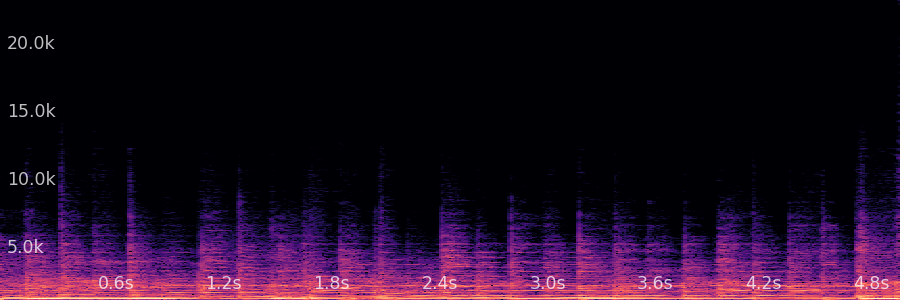
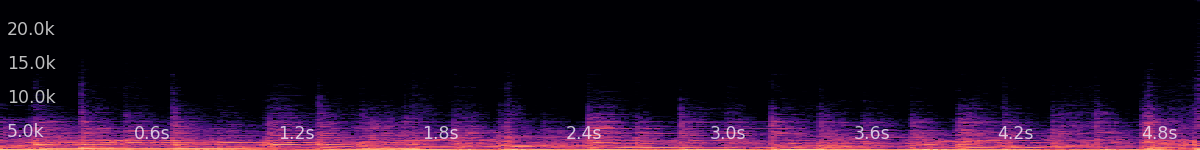

In [ ]:
# generate the output tokens
output_tokens = interface.vamp(
    tokens, mask, return_mask=False,
    sampling_temperature=1.0,
    typical_filtering=False,
    top_p=0.8,
    sample_cutoff=1.0,
)

# convert them to a signal
output_signal = interface.decode(output_tokens).cpu()

# save the output signal
Path("scratch").mkdir(exist_ok=True)
output_signal.widget()
output_signal.write("scratch/output.wav")